In [17]:
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sb

#### hyperparameter tuning of the RF model

In [2]:
df = pd.read_csv('DNS_datastore.csv', index_col=0)

features = list(df.columns)[11:]

x = np.array(df.loc[:,features].fillna(0))
y = np.array(df['Label'])

In [3]:
mu = 0
sigma = (0.03 * x.mean(axis=0))
noise = np.random.normal(mu, sigma, size=x.shape)

x = x + noise

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [5]:
def cm(rf, x, y):
    y_predict = rf.predict(x)
    cm = confusion_matrix(y, y_predict)
    names = ['TN','FP','FN','TP']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percents = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percents)]
    labels = np.asarray(labels).reshape(2,2)
    plt.title('Confusion Matrix')
    fig = sb.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False).get_figure()

    TN, FP, FN, TP =  [int(x) for x in np.asarray(cm).reshape(-1)]
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    metrics = pd.DataFrame(columns=['Evaluation Metric (other names)','Equation','Value'])
    metrics.loc['Accuracy',:] = ['', 'TN+TP / total', '%.2f%%' %((TN+TP)/(TN+TP+FN+FP)*100)]
    metrics.loc['True Positive Rate',:] = ['Sensitivity, Recall', 'TP/(TP+FN)', '%.2f%%' %(recall*100)]
    metrics.loc['True Negative Rate',:] = ['Specificity', 'TN/(TN+FN)', '%.2f%%' %(TN/(TN+FN)*100)]
    metrics.loc['False Positive Rate',:] = ['Fall-Out', 'FP/(TN+FN)', '%.2f%%' %(FP/(TN+FN)*100)]
    metrics.loc['False Negative Rate',:] = ['Miss Rate', 'TN/(FN+TP)', '%.2f%%' %(FN/(FN+TP)*100)]
    metrics.loc['Positive Predictive Value',:] = ['Precision', 'TP/(TP+FP)', '%.2f%%' %(precision*100)]
    metrics.loc['False Discovery Rate',:] = ['', 'FP/(FP+TP)', '%.2f%%' %(FP/(FP+TP)*100)]
    metrics.loc['F-1 Score',:] = ['', '2*(Recall*Precision) /(Recall+Precision)', \
                                  '%.2f%%' %(2*(recall*precision)/(recall+precision)*100)]
    display(metrics)
    return (TN+TP)/(TN+TP+FN+FP)*100

In [6]:
%%time
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2'] + list(np.linspace(0,1,11)),
    'max_depth': list(range(2,6)),
    'max_features': list(range(2,15)),
    'min_samples_leaf': list(np.linspace(0,1,11)),
    'min_samples_split': list(np.linspace(0,1,11)),
    'n_estimators': list(range(2,15))
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 81796 candidates, totalling 245388 fits


C:\Users\OpEx-ProEye\Anaconda3\envs\ml-env\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 12}


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [15]:
[0.1*x for x in range(1,11)]

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

,Evaluation Metric (other names),Equation,Value
Accuracy,,TN+TP / total,99.97%
True Positive Rate,"Sensitivity, Recall",TP/(TP+FN),99.97%
True Negative Rate,Specificity,TN/(TN+FN),99.86%
False Positive Rate,Fall-Out,FP/(TN+FN),0.00%
False Negative Rate,Miss Rate,TN/(FN+TP),0.03%
Positive Predictive Value,Precision,TP/(TP+FP),100.00%
False Discovery Rate,,FP/(FP+TP),0.00%
F-1 Score,,2*(Recall*Precision) /(Recall+Precision),99.98%


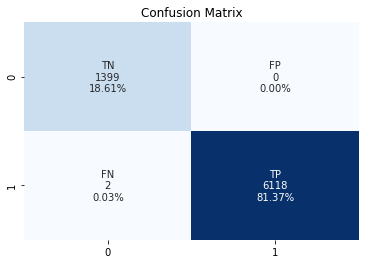

In [12]:
base_rf = RandomForestClassifier()
base_rf.fit(x_train, y_train)
base_accuracy = cm(base_rf, x_test, y_test)

{'bootstrap': True,
 'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'n_estimators': 12}


,Evaluation Metric (other names),Equation,Value
Accuracy,,TN+TP / total,99.96%
True Positive Rate,"Sensitivity, Recall",TP/(TP+FN),100.00%
True Negative Rate,Specificity,TN/(TN+FN),100.00%
False Positive Rate,Fall-Out,FP/(TN+FN),0.21%
False Negative Rate,Miss Rate,TN/(FN+TP),0.00%
Positive Predictive Value,Precision,TP/(TP+FP),99.95%
False Discovery Rate,,FP/(FP+TP),0.05%
F-1 Score,,2*(Recall*Precision) /(Recall+Precision),99.98%


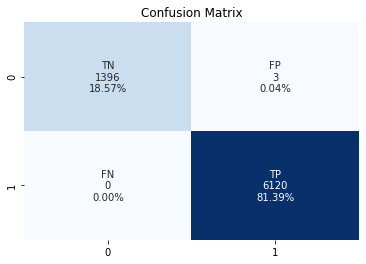

In [10]:
pprint(grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = cm(best_grid, x_test, y_test)

#### feature selection

In [18]:
sel = SelectFromModel(best_grid)
sel.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=3, max_features=10,
                                                 min_samples_leaf=0.1,
                                                 min_samples_split=0.1,
                                                 n_estimators=12))

In [34]:
selected_feat= df.loc[:,features].columns[(sel.get_support())]
print(selected_feat)

Index(['Subdomain Entropy', 'Numeric Count', 'Payload Lowercase Count',
       'Payload Special Char Count', 'Avg Subdomain Length (Session)'],
      dtype='object')


<AxesSubplot:>

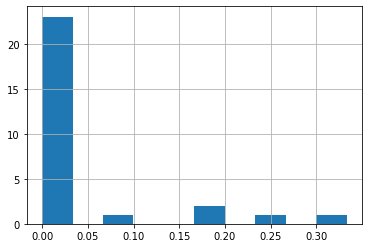

In [38]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

#### compare to DT/SVM/KNN